In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score,classification_report,f1_score
from sklearn.model_selection import train_test_split, GridSearchCV
import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer 
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt 

import math
import torch
from torch import nn
from torch import optim
from torchvision.datasets import MNIST
from torch.utils.data import TensorDataset, DataLoader

import torch.nn.functional as F

from torch.autograd import Variable
from torchvision import datasets, transforms
import torch.utils.data as utils
from torch.optim import Adam 

In [149]:
trainloader = torch.utils.data.DataLoader(
        torch.utils.data.Subset(datasets.MNIST('MNIST_data/', train=True, download=False,
                       transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])) , list(range(0 , 60000 , 110))),
        batch_size=16, shuffle=True)
test_loader = torch.utils.data.DataLoader(
        datasets.MNIST('MNIST_data/', train=False, transform=transforms.Compose([
                           transforms.ToTensor(),
                           transforms.Normalize((0.1307,), (0.3081,))
                       ])),
        batch_size=16, shuffle=True)

In [150]:
len(trainloader)*16

560

In [151]:
len(test_loader)*16

10000

In [152]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)
device = torch.device('cpu')

cuda


In [153]:
def call_pr_loss(a , variance):
    k = len(a[0])
    l = torch.sum(a**2)/ variance**2 /2/k
    return k/2*math.log(2*math.pi) + 0.5*k*math.log(variance) + l

In [154]:
def eva(test_loader , model):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            data = data.view(data.size(0), -1)
            output = model(data)
            test_loss += criterion(output, target).item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    
    print('\nTest set: Average loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
        test_loss, correct, len(test_loader.dataset),
        100. * correct / len(test_loader.dataset)))
    
    return (test_loss ,correct / len(test_loader.dataset) )

In [179]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 400))
model.add_module('r1', nn.Sigmoid())
model.add_module('l2', nn.Linear(400, 400))
model.add_module('r2', nn.Sigmoid())
model.add_module('l3', nn.Linear(400, 400))
model.add_module('r3', nn.Sigmoid())
model.add_module('l4', nn.Linear(400, 400))
model.add_module('r4', nn.Sigmoid())
model.add_module('l5', nn.Linear(400, 400))
model.add_module('r5', nn.Sigmoid())
model.add_module('lf', nn.Linear(400, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (r1): Sigmoid()
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (r2): Sigmoid()
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (r3): Sigmoid()
  (l4): Linear(in_features=400, out_features=400, bias=True)
  (r4): Sigmoid()
  (l5): Linear(in_features=400, out_features=400, bias=True)
  (r5): Sigmoid()
  (lf): Linear(in_features=400, out_features=10, bias=True)
)

In [180]:
m_200 = 10
m_784 = 10
NUM_EPOCH = 500

In [181]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, NUM_EPOCH):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_5 = call_pr_loss(model.l5.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 +  loss_4 + loss_5 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))


Train Epoch: 29 [304/546 (54%)]	Loss: 5763.818359 
Train Epoch: 58 [64/546 (11%)]	Loss: 5763.561523 
Train Epoch: 86 [384/546 (69%)]	Loss: 5763.550293 
Train Epoch: 115 [144/546 (26%)]	Loss: 5763.544434 
Train Epoch: 143 [464/546 (83%)]	Loss: 5763.554199 
Train Epoch: 172 [224/546 (40%)]	Loss: 5763.547852 
Train Epoch: 200 [68/546 (97%)]	Loss: 5763.543945 
Train Epoch: 229 [304/546 (54%)]	Loss: 5763.556641 
Train Epoch: 258 [64/546 (11%)]	Loss: 5763.550781 
Train Epoch: 286 [384/546 (69%)]	Loss: 5763.544922 
Train Epoch: 315 [144/546 (26%)]	Loss: 5763.541504 
Train Epoch: 343 [464/546 (83%)]	Loss: 5763.538574 
Train Epoch: 372 [224/546 (40%)]	Loss: 5763.550293 
Train Epoch: 400 [68/546 (97%)]	Loss: 5763.545410 
Train Epoch: 429 [304/546 (54%)]	Loss: 5763.541992 
Train Epoch: 458 [64/546 (11%)]	Loss: 5763.538574 
Train Epoch: 486 [384/546 (69%)]	Loss: 5763.549316 


In [182]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.0741, Accuracy: 8350/10000 (84%)



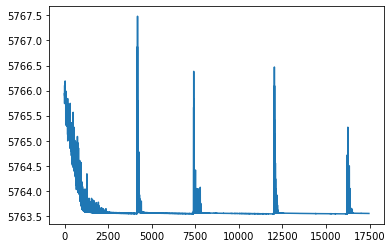

In [183]:
plt.plot(loss_history)

In [184]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 400))
model.add_module('r1', nn.Sigmoid())
model.add_module('l2', nn.Linear(400, 400))
model.add_module('r2', nn.Sigmoid())
model.add_module('l3', nn.Linear(400, 400))
model.add_module('r3', nn.Sigmoid())
model.add_module('l4', nn.Linear(400, 400))
model.add_module('r4', nn.Sigmoid())

model.add_module('l5', nn.Linear(400, 400))
model.add_module('r5', nn.Sigmoid())

model.add_module('lf', nn.Linear(400, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (r1): Sigmoid()
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (r2): Sigmoid()
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (r3): Sigmoid()
  (l4): Linear(in_features=400, out_features=400, bias=True)
  (r4): Sigmoid()
  (l5): Linear(in_features=400, out_features=400, bias=True)
  (r5): Sigmoid()
  (lf): Linear(in_features=400, out_features=10, bias=True)
)

In [185]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)


model.train()
step = 0 
loss_history = []
for epoch in range(1, NUM_EPOCH):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        #loss_1 = call_pr_loss(model.l1.weight , m_784)
        #loss_2 = call_pr_loss(model.l2.weight , m_200)
        #loss_3 = call_pr_loss(model.l3.weight , m_200)
        #loss_4 = call_pr_loss(model.l4.weight , m_200)
        #loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0# + loss_1+ loss_2+ loss_3 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
    

Train Epoch: 29 [304/546 (54%)]	Loss: 0.096099 
Train Epoch: 58 [64/546 (11%)]	Loss: 0.010769 
Train Epoch: 86 [384/546 (69%)]	Loss: 0.002144 
Train Epoch: 115 [144/546 (26%)]	Loss: 0.000863 
Train Epoch: 143 [464/546 (83%)]	Loss: 0.000496 
Train Epoch: 172 [224/546 (40%)]	Loss: 0.000164 
Train Epoch: 200 [68/546 (97%)]	Loss: 0.000132 
Train Epoch: 229 [304/546 (54%)]	Loss: 0.000068 
Train Epoch: 258 [64/546 (11%)]	Loss: 0.000027 
Train Epoch: 286 [384/546 (69%)]	Loss: 0.000023 
Train Epoch: 315 [144/546 (26%)]	Loss: 0.000012 
Train Epoch: 343 [464/546 (83%)]	Loss: 0.000006 
Train Epoch: 372 [224/546 (40%)]	Loss: 0.000004 
Train Epoch: 400 [68/546 (97%)]	Loss: 0.000003 
Train Epoch: 429 [304/546 (54%)]	Loss: 0.000002 
Train Epoch: 458 [64/546 (11%)]	Loss: 0.000001 
Train Epoch: 486 [384/546 (69%)]	Loss: 0.000000 


In [186]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.1412, Accuracy: 8300/10000 (83%)



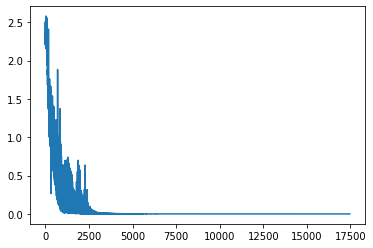

In [187]:
plt.plot(loss_history)

In [173]:
m_200 = 5
m_784 = 5
NUM_EPOCH = 100

In [174]:
model = nn.Sequential()
model.add_module('l1', nn.Linear(784, 400))
model.add_module('r1', nn.Sigmoid())
model.add_module('l2', nn.Linear(400, 400))
model.add_module('r2', nn.Sigmoid())
model.add_module('l3', nn.Linear(400, 400))
model.add_module('r3', nn.Sigmoid())
model.add_module('l4', nn.Linear(400, 400))
model.add_module('r4', nn.Sigmoid())

model.add_module('l5', nn.Linear(400, 400))
model.add_module('r5', nn.Sigmoid())

model.add_module('lf', nn.Linear(400, 10))

model.to(device)

Sequential(
  (l1): Linear(in_features=784, out_features=400, bias=True)
  (r1): Sigmoid()
  (l2): Linear(in_features=400, out_features=400, bias=True)
  (r2): Sigmoid()
  (l3): Linear(in_features=400, out_features=400, bias=True)
  (r3): Sigmoid()
  (l4): Linear(in_features=400, out_features=400, bias=True)
  (r4): Sigmoid()
  (l5): Linear(in_features=400, out_features=400, bias=True)
  (r5): Sigmoid()
  (lf): Linear(in_features=400, out_features=10, bias=True)
)

In [175]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
#scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=1, gamma=0.1)

model.train()
step = 0 
loss_history = []
for epoch in range(1, NUM_EPOCH):
    for batch_idx, (data, target) in enumerate(trainloader):
        
        data, target = data.to(device), target.to(device)
        data = data.view(data.size(0), -1)
        optimizer.zero_grad()
        output = model(data)
        loss_0 = criterion(output, target)
        loss_1 = call_pr_loss(model.l1.weight , m_784)
        loss_2 = call_pr_loss(model.l2.weight , m_200)
        loss_3 = call_pr_loss(model.l3.weight , m_200)
        loss_4 = call_pr_loss(model.l4.weight , m_200)
        loss_5 = call_pr_loss(model.l5.weight , m_200)
        loss_f = call_pr_loss(model.lf.weight , m_200)
        
        
        loss = loss_0 + loss_1+ loss_2+ loss_3 +  loss_4 + loss_5 + loss_f
        loss.backward()
        optimizer.step()
        step += 1
        loss_history.append(loss.item())
        if step % 1000  == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f} '.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))

Train Epoch: 29 [304/546 (54%)]	Loss: 4799.506348 
Train Epoch: 58 [64/546 (11%)]	Loss: 4798.965332 
Train Epoch: 86 [384/546 (69%)]	Loss: 4798.770020 


In [176]:
 c, d = eva(test_loader , model)


Test set: Average loss: 0.1097, Accuracy: 7172/10000 (72%)



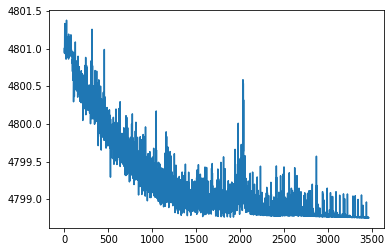

In [177]:
plt.plot(loss_history)